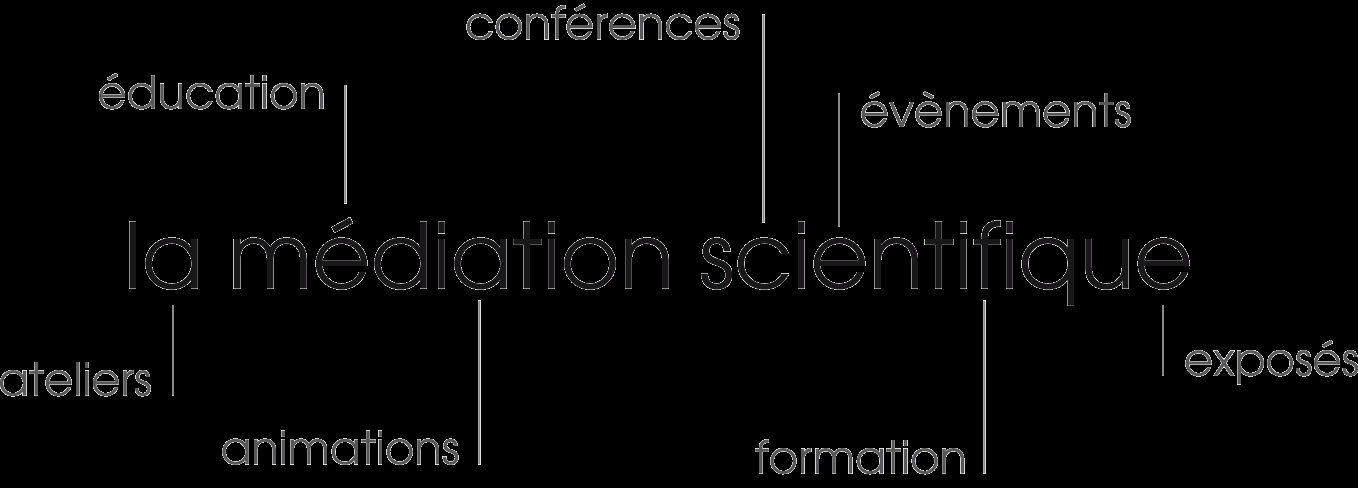

In [8]:
import sys
sys.path.insert(0, '..')
from app.processing.BaseDocumentProcessor import BaseDocumentProcessor
import os
import fitz
import io
from app.schemas import Document, DocumentChunk, MediaType
from IPython.display import display, Image
import PIL.Image
import base64

class PDFProcessor(BaseDocumentProcessor):
    def __init__(self, client, pdf_path: str):
        self.pdf_path = pdf_path
        super().__init__(client)
    
    def keep_image(self, width, height):
        aspect_ratio = width / height
        res_megapixel = (width * height) / 1000000

        if (res_megapixel < 0.05):
            return False

        # Check if aspect ratio is within an acceptable range
        min_aspect_ratio = 0.2
        max_aspect_ratio = 6
        if aspect_ratio < min_aspect_ratio or aspect_ratio > max_aspect_ratio:
            return False

        return True
    def get_pdf_image_chunks(self, path: str):
        pdf_document = fitz.open(path)
        images_tuple = []

        for page_num in range(len(pdf_document)):
            page = pdf_document[page_num]
            image_list = page.get_images(full=True)
            
            for img_index, img in enumerate(image_list):
                
                xref = img[0]
                base_image = pdf_document.extract_image(xref)
                width = base_image.get('width', 0)
                height = base_image.get('height', 0)
                if (self.keep_image(width, height)):
                    # here check if image['width'] x height < n -> discard low res
                    image_bytes = base_image["image"]
                    # Convertir les bytes en image PIL
                    image = PIL.Image.open(io.BytesIO(image_bytes))
                    
                    # Convertir l'image PIL en base64
                    buffered = io.BytesIO()
                    image.save(buffered, format="PNG")
                    img_str = base64.b64encode(buffered.getvalue()).decode()
                    
                    images_tuple.append((img_str, image))

        pdf_document.close()
        return images_tuple


    def extract_document(self):
        return self.get_pdf_image_chunks(self.pdf_path), None
        
        # chunks = [DocumentChunk(
        #     text=segment.text,
        #     media_type=MediaType.YOUTUBE,
        #     start_offset=int(segment.start), 
        #     end_offset=int(segment.end)
        # ) for segment in segments]
        # document = Document(
        #     chunks=chunks,
        #     document_id=self.id, 
        #     local_path=video_path, 
        #     original_public_path=self.youtube_url,
        #     media_name=video_name,
        # )

        # return document, chunks
pdf = PDFProcessor(None, './data/test_2.pdf')
x, y = pdf.extract_document()
x[0][1]